# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

Develop a predictive model that analyzes historical used car transaction data to determine the key features that affect used car valuation. This will involve collecting data on various attributes of cars, such as make, model, year, mileage, condition, and any additional features, and using statistical analysis or machine learning techniques to understand how each attribute correlates with the car's sale price. The goal is to quantify the impact of these features on the price to guide pricing strategies and value estimations for used cars.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns

In [ ]:
data = pd.read_csv('../../Downloads/practical_application_II_starter/data/vehicles.csv')

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [ ]:
data.describe()

In [ ]:
data[['price', 'year', 'odometer']].corr()

Review data, analyze metadata of data, identify missing values or challenging properties

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
plt.rcParams["figure.autolayout"] = True

#create seaborn heatmap
ax = sns.heatmap(data[['price', 'year', 'odometer']].corr(), annot = True)

# Adding Title to the Plot
ax.set_title("Correlation Heatmap of the Raw Datasets")
manager = plt.get_current_fig_manager()
manager.full_screen_toggle()
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(data['year'], data['price'])

plt.title("Price over Years")
 
# Setting the X and Y labels
plt.xlabel('Years')
plt.ylabel('Car Prices')
plt.colorbar()
 
plt.show()

In [ ]:
#Drop "id" and "VIN". They are match keys and won't be used in modeling.
df = data.drop(columns = ['id','VIN'])
df.shape

In [ ]:
df['condition'].value_counts()

In [ ]:
df = df.query('condition != "new"')
df.shape

In [ ]:
df.isna().sum()

In [ ]:
#Drop records with 'year' and 'odometer' missing
df2 = df.dropna(subset = ['year','odometer'])

#Replace the other categorical variables with missing values with 'missing'
for i in df2.columns:
    df2.loc[:, i] = df2[i].fillna("unknown")
    
df2.shape

In [ ]:
df2.isna().sum()

In [ ]:
df2

In [ ]:
# Binning odometer readings into categories for analysis
df2.loc[:, "odometer_bin"] = pd.cut(x=df2["odometer"], 
                             bins=[0, 1, 10, 100, 1000, 999_999, float('inf')], 
                             right=False,
                             labels=["0-1", "1-10", "10-100", "100-1K", "1K-999K", "999K+"])

df2['odometer_bin'].value_counts().sort_index()

In [ ]:
df2 = df2[(df2['odometer'] > 0) & (df2['odometer'] < 1_000_000)]
df2.shape

In [ ]:
year_bin = [1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2020,2022,float("inf")]
df2.loc[:, "year_bin"] = pd.cut(x=df2["year"], 
                             bins=year_bin, 
                             right=False)

df2['year_bin'].value_counts().sort_index()

In [ ]:
df2 = df2[(df2['year'] >= 1990)]
df2.shape

In [ ]:
df2 = df2.drop(columns = ['odometer_bin','year_bin'])

In [ ]:
# Assuming df is your DataFrame
for column in df.columns:
    unique_values = len(df[column].unique())
    print(f"Unique values in '{column}': {unique_values}")

In [ ]:
df2 = df2.drop(columns = ['region','model'])
df2.shape

In [ ]:
# Define a list of lists containing US state codes by census division
census_divisions = [
    ['wa', 'or', 'ca', 'ak', 'hi'],  # Pacific
    ['mt', 'id', 'wy', 'nv', 'ut', 'co', 'az', 'nm'],  # Mountain
    ['nd', 'sd', 'ne', 'ks', 'mo', 'ia', 'mn'],  # West North Central
    ['ok', 'tx', 'ar', 'la'],  # West South Central
    ['wi', 'il', 'mi', 'in', 'oh'],  # East North Central
    ['ky', 'tn', 'ms', 'al'],  # East South Central
    ['ny', 'pa', 'nj'],  # Middle Atlantic
    ['wv', 'va', 'de', 'md', 'dc', 'nc', 'sc', 'ga', 'fl'],  # South Atlantic
    ['nh', 'vt', 'me', 'ma', 'ri', 'ct']  # New England
]

# Calculate the sum of the lengths of all lists in the container
total_states = sum(len(division) for division in census_divisions)

print(f'Number of states including DC is {total_states}')

In [ ]:
divisions = {
    'Pacific': ['wa', 'or', 'ca', 'ak', 'hi'],
    'Mountain': ['mt', 'id', 'wy', 'nv', 'ut', 'co', 'az', 'nm'],
    'West North Central': ['nd', 'sd', 'ne', 'ks', 'mo', 'ia', 'mn'],
    'West South Central': ['ok', 'tx', 'ar', 'la'],
    'East North Central': ['wi', 'il', 'mi', 'in', 'oh'],
    'East South Central': ['ky', 'tn', 'ms', 'al'],
    'Middle Atlantic': ['ny', 'pa', 'nj'],
    'South Atlantic': ['wv', 'va', 'de', 'md', 'dc', 'nc', 'sc', 'ga', 'fl'],
    'New England': ['nh', 'vt', 'me', 'ma', 'ri', 'ct']
}

# Invert the dictionary to map state to division
state_to_division = {state: division for division, states in divisions.items() for state in states}
df2['state_division'] = df2['state'].map(state_to_division)

In [ ]:
state_to_division

In [ ]:
df2 = df2.drop(columns = ['state'])
df2.shape

In [ ]:
# Assuming df is your DataFrame
for column in df2.columns:
    unique_values = len(df2[column].unique())
    print(f"Unique values in '{column}': {unique_values}")

In [ ]:
df2['manufacturer'].unique()

In [ ]:
manufacturer_origin = {
    'Domestic': ['tesla', 'ram', 'gmc', 'ford', 'cadillac', 'jeep', 'lincoln', 'chevrolet', 'dodge', 'buick', 'harley-davidson', 'chrysler', 'pontiac', 'mercury', 'saturn'],
    'Britain': ['aston-martin', 'rover', 'jaguar', 'mini', 'land rover', 'morgan'],
    'Germany': ['porsche', 'audi', 'mercedes-benz', 'bmw', 'volkswagen'],
    'Italy': ['ferrari', 'alfa-romeo', 'fiat'],
    'Japan': ['infiniti', 'acura', 'lexus', 'toyota', 'datsun', 'mitsubishi', 'subaru', 'mazda', 'nissan', 'honda'],
    'Korea': ['kia', 'hyundai'],
    'Sweden': ['volvo'],
    'Unknown': ['unknown']
}

manufacturer_to_country = {manufacturer: country for country, manufacturers in manufacturer_origin.items() for manufacturer in manufacturers}
manufacturer_to_country

In [ ]:
df2['country_of_origin'] = df2['manufacturer'].map(manufacturer_to_country)

In [ ]:
unique_manufacturers = df2['manufacturer'].unique()
print(f"Unique manufacturers in dataset: {len(unique_manufacturers)}")


In [ ]:
print(df2['country_of_origin'].value_counts())

In [ ]:
df2['country_of_origin'].isna().sum()

In [ ]:
df2 = df2.drop(columns=['manufacturer'])

In [ ]:
df2.info()

In [ ]:
df2 = df2.query('price > 0')
df2.shape

In [ ]:
df2

In [ ]:
df2.describe()

In [ ]:
price_bin = [0,500,1000,100_000,200_000,float("inf")]
df2.loc[:, "price_bin"] = pd.cut(x=df2["price"], 
                             bins=price_bin, 
                             right=False)

df2['price_bin'].value_counts().sort_index()

In [ ]:
df2 = df2[(df2['price'] >= 500) & (df2['price'] < 100_000)]
df2.drop(columns='price_bin')
df2.shape

In [ ]:
#Plot the histogram of the price for the used cars
plt.hist(df2['price']);
plt.xlabel("Price of Used Car ($)")
plt.ylabel("Number of Cars")
plt.title('Distribution of the Price of the Used Cars')
plt.tight_layout()

In [ ]:
#Apply log transformation on the price to get a normal distribution
df2.loc[:, 'log_price'] = np.log(df2['price'])
plt.hist(df2['log_price']);
plt.xlabel("Log-Price of Used Car ($)")
plt.ylabel("Number of Cars")
plt.title('Distribution of the Log-Price of the Used Cars');

In [ ]:
sns.pairplot(df2[['year','odometer','log_price']]);

In [ ]:
odometer_bins = [0, 10_000, 20_000, 30_000, 40_000, 50_000, 60_000, 70_000, 80_000, 90_000, 100_000, 110_000, 120_000, 130_000, 140_000, 150_000, 160_000, 170_000, 180_000, 190_000, 200_000, float('inf')]
odometer_labels = ['<10k', '10-20k', '20-30k', '30-40k', '40-50k', '50-60k', '60-70k', '70-80k', '80-90k', '90-100k', '100-110k', '110-120k', '120-130k', '130-140k', '140-150k', '150-160k', '160-170k', '170-180k', '180-190k', '190-200k', '>200k']
df2['odometer_bin'] = pd.cut(df2['odometer'], bins=odometer_bins, labels=odometer_labels, right=False)

# Set up the matplotlib figure with two subplots
fig, ax = plt.subplots(2, 1, figsize=(20, 15))

# Violin plot for log-car price by 'year'
sns.violinplot(ax=ax[0], x='year', y='log_price', data=df2)
ax[0].set_title('Distribution of Car Log-Price by Year', fontsize=20)
ax[0].set_xlabel('Year', fontsize=15)
ax[0].set_ylabel('Log-Price of Used Cars ($)', fontsize=15)
ax[0].tick_params(axis='x', rotation=45, labelsize=15)

# Violin plot for log-car price by 'odometer_bin'
sns.violinplot(ax=ax[1], x='odometer_bin', y='log_price', data=df2)
ax[1].set_title('Distribution of Car Log-Price by Odometer Bins', fontsize=20)
ax[1].set_xlabel('Odometer Bins (miles)', fontsize=15)
ax[1].set_ylabel('Log-Price of Used Cars ($)', fontsize=15)
ax[1].tick_params(axis='x', rotation=45, labelsize=15)

# Adjust layout for readability
fig.tight_layout()
plt.show()

In [ ]:
df2 = df2.drop(columns=['odometer_bin', 'price_bin'])

In [ ]:
categories = []
for i in df2.columns:
    categories.append((i,df2[i].unique()))

categories

In [ ]:
categories.pop(0)
categories.pop(0)
categories.pop(3)
categories.pop(-1)
categories

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(20, 25))
axes = axes.flatten()  # Flatten to 1D array for easy iteration

for i, (category, order) in enumerate(categories):
    ax = axes[i]
    sns.violinplot(ax=ax, x=category, y='log_price', data=df2, order=order)
    ax.set_title(f"Distribution of Car Log-Price by {category.title()}", fontsize=20)
    ax.set_ylabel("Car Log-Price", fontsize=15)
    ax.set_xlabel(category.title(), fontsize=15)
    ax.tick_params(axis='x', labelrotation=45, labelsize=15)

# Adjust layout to prevent overlap
fig.tight_layout()

# Display the plot
plt.show()

In [ ]:
df2.info()

In [ ]:
df2.loc[:,'title_status'] = df2['title_status'].replace({'missing': 'unknown'})

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

Year to Age: Transforming 'year' into 'vehicle_age' is an excellent move. It directly relates to depreciation and is more intuitive for modeling.

Manufacturer + Type + Paint Color: Grouping less common manufacturers under 'other' and considering the type of car along with paint color can create a comprehensive feature that encapsulates the brand's market value, type's demand, and color preference impact.

Odometer to Mileage Categories: Categorizing 'odometer' readings into 'high mileage' vs. 'low mileage' simplifies the data and directly addresses the common buyer's concern about wear and tear.

Drive and Transmission Combined: This could offer a unique insight into the car's performance characteristics that appeal to certain buyer segments.

In [ ]:
listOneHotEncode = ['condition','cylinders','fuel','title_status','transmission','drive','size','type',
                    'paint_color','state_division',"country_of_origin"]

one_hot_encoded_df = pd.get_dummies(df2[listOneHotEncode], drop_first=True, dtype='int')
df3 = df2.copy()
df3.drop(columns=listOneHotEncode, inplace=True)
df3 = pd.concat([df3, one_hot_encoded_df], axis=1)
df3.shape

In [ ]:
df3 = df3.drop(columns='price')
df3.shape

In [ ]:
df3.head()

In [ ]:
# Scaling
scaler = StandardScaler()
df3[['year', 'odometer']] = scaler.fit_transform(df3[['year', 'odometer']])

In [ ]:
df3[['year', 'odometer']].head()

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [ ]:
X = df3.drop(columns = ['log_price'])
y = df3['log_price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
from sklearn.linear_model import LassoCV

# Use LassoCV for automatic alpha selection
lasso = LassoCV(cv=5, random_state=42).fit(X_train, y_train)

# Get the features selected by Lasso
selected_features = X.columns[(lasso.coef_ != 0)]

print("Selected Features:", selected_features)

In [ ]:
X_train[selected_features].info()

In [ ]:
lin = LinearRegression()
lin.fit(X_train[selected_features], y_train)
y_pred_train_lin = lin.predict(X_train[selected_features])
y_pred_test_lin = lin.predict(X_test[selected_features])
mse_train_lin = mean_squared_error(y_train, y_pred_train_lin)
mse_test_lin = mean_squared_error(y_test, y_pred_test_lin)
r2_train_lin = r2_score(y_train, y_pred_train_lin)
r2_test_lin = r2_score(y_test, y_pred_test_lin)

print("MSE Train:", mse_train_lin)
print("MSE Test:", mse_test_lin)
print("R2 Train:", r2_train_lin)
print("R2 Test:", r2_test_lin)

In [ ]:
lasso = Lasso()
lasso.fit(X_train[selected_features], y_train)
y_pred_train_lasso = lasso.predict(X_train[selected_features])
y_pred_test_lasso = lasso.predict(X_test[selected_features])
mse_train_lasso = mean_squared_error(y_train, y_pred_train_lasso)
mse_test_lasso = mean_squared_error(y_test, y_pred_test_lasso)
r2_train_lasso = r2_score(y_train, y_pred_train_lasso)
r2_test_lasso = r2_score(y_test, y_pred_test_lasso)

print("MSE Train:", mse_train_lasso)
print("MSE Test:", mse_test_lasso)
print("R2 Train:", r2_train_lasso)
print("R2 Test:", r2_test_lasso)

In [ ]:
ridge = Ridge()
ridge.fit(X_train[selected_features], y_train)
y_pred_train_ridge = ridge.predict(X_train[selected_features])
y_pred_test_ridge = ridge.predict(X_test[selected_features])
mse_train_ridge = mean_squared_error(y_train, y_pred_train_ridge)
mse_test_ridge = mean_squared_error(y_test, y_pred_test_ridge)
r2_train_ridge = r2_score(y_train, y_pred_train_ridge)
r2_test_ridge = r2_score(y_test, y_pred_test_ridge)

print("MSE Train:", mse_train_ridge)
print("MSE Test:", mse_test_ridge)
print("R2 Train:", r2_train_ridge)
print("R2 Test:", r2_test_ridge)

In [ ]:
fig = px.scatter(x=y_test, y=y_pred_test_ridge, trendline='ols')

fig.update_layout(
    xaxis_title="Actual Values",
    yaxis_title="Predicted Values (Log Scale)"
)

trendline_trace_index = 1  # This may need to be adjusted based on your specific figure
trendline_color = "#FFA15A"  # Example color

fig.data[trendline_trace_index].line.color = trendline_color

fig.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

ridge = Ridge()
ridge = GridSearchCV(estimator=ridge, param_grid={"alpha": np.logspace(0, 10, 50)}, scoring="neg_mean_squared_error")

ridge.fit(X_train[selected_features], y_train)
y_pred_train_ridge = ridge.predict(X_train[selected_features])
y_pred_test_ridge = ridge.predict(X_test[selected_features])
mse_train_ridge = mean_squared_error(y_train, y_pred_train_ridge)
mse_test_ridge = mean_squared_error(y_test, y_pred_test_ridge)
r2_train_ridge = r2_score(y_train, y_pred_train_ridge)
r2_test_ridge = r2_score(y_test, y_pred_test_ridge)

print("MSE Train:", mse_train_ridge)
print("MSE Test:", mse_test_ridge)
print("R2 Train:", r2_train_ridge)
print("R2 Test:", r2_test_ridge)

print(ridge.best_estimator_)

In [ ]:
mae_train_ridge = mean_absolute_error(y_train, y_pred_train_ridge)
mae_test_ridge = mean_absolute_error(y_test, y_pred_test_ridge)

print("MAE Train:", mae_train_ridge)
print("MAE Test:", mae_test_ridge)

In [ ]:
pipe = Pipeline([('poly',PolynomialFeatures(degree = 2, include_bias=False)), ('lin', LinearRegression())])
# rs = RandomizedSearchCV(estimator=pipeline, param_distributions={"poly__degree": [1,2,3]}, scoring="neg_mean_squared_error")
pipe.fit(X_train[selected_features], y_train)

y_pred_train_pipe_lin = pipe.predict(X_train[selected_features])
y_pred_test_pipe_lin = pipe.predict(X_test[selected_features])
mse_train_pipe_lin = mean_squared_error(y_train, y_pred_train_pipe_lin)
mse_test_pipe_lin = mean_squared_error(y_test, y_pred_test_pipe_lin)
r2_train_pipe_lin = r2_score(y_train, y_pred_train_pipe_lin)
r2_test_pipe_lin = r2_score(y_test, y_pred_test_pipe_lin)

print("MSE Train:", mse_train_pipe_lin)
print("MSE Test:", mse_test_pipe_lin)
print("R2 Train:", r2_train_pipe_lin)
print("R2 Test:", r2_test_pipe_lin)

In [ ]:
mae_train_pipe_lin = mean_absolute_error(y_train, y_pred_train_pipe_lin)
mae_test_pipe_lin = mean_absolute_error(y_test, y_pred_test_pipe_lin)

print("MAE Train:", mae_train_pipe_lin)
print("MAE Test:", mae_test_pipe_lin)

In [ ]:
fig = px.scatter(x=y_test, y=y_pred_test_pipe_lin, trendline='ols')

fig.update_layout(
    xaxis_title="Actual Values",
    yaxis_title="Predicted Values (Log Scale)"
)

trendline_trace_index = 1  # This may need to be adjusted based on your specific figure
trendline_color = "#FFA15A"  # Example color

fig.data[trendline_trace_index].line.color = trendline_color

fig.show()

In [ ]:
fig = px.scatter(x=np.exp(y_test), y=np.exp(y_pred_test_pipe_lin), trendline='ols')

fig.update_layout(yaxis_type="log")

# Update axis labels if needed
fig.update_layout(
    xaxis_title="Actual Values",
    yaxis_title="Predicted Values (Log Scale)"
)

trendline_trace_index = 1  # This may need to be adjusted based on your specific figure
trendline_color = "#FFA15A"  # Example color

fig.data[trendline_trace_index].line.color = trendline_color


fig.show()

In [ ]:
ridge = Ridge(alpha = 1.599858719606058)
ridge = Pipeline([('poly',PolynomialFeatures(degree = 3, include_bias=False)), ('ridge', ridge)])

ridge.fit(X_train[selected_features], y_train)
y_pred_train_ridge = ridge.predict(X_train[selected_features])
y_pred_test_ridge = ridge.predict(X_test[selected_features])
mse_train_ridge = mean_squared_error(y_train, y_pred_train_ridge)
mse_test_ridge = mean_squared_error(y_test, y_pred_test_ridge)
r2_train_ridge = r2_score(y_train, y_pred_train_ridge)
r2_test_ridge = r2_score(y_test, y_pred_test_ridge)

print("MSE Train:", mse_train_ridge)
print("MSE Test:", mse_test_ridge)
print("R2 Train:", r2_train_ridge)
print("R2 Test:", r2_test_ridge)

In [ ]:
mae_train_ridge = mean_absolute_error(y_train, y_pred_train_ridge)
mae_test_ridge = mean_absolute_error(y_test, y_pred_test_ridge)

print("MAE Train:", mae_train_ridge)
print("MAE Test:", mae_test_ridge)

In [ ]:
fig = px.scatter(x=y_test, y=y_pred_test_ridge, trendline='ols')

# Update axis labels if needed
fig.update_layout(
    xaxis_title="Actual Values",
    yaxis_title="Predicted Values"
)

trendline_trace_index = 1  # This may need to be adjusted based on your specific figure
trendline_color = "#FFA15A"  # Example color

fig.data[trendline_trace_index].line.color = trendline_color


fig.show()

In [ ]:
fig = px.scatter(x=np.exp(y_test), y=np.exp(y_pred_test_ridge), trendline='ols')

fig.update_layout(yaxis_type="log")

# Update axis labels if needed
fig.update_layout(
    xaxis_title="Actual Values",
    yaxis_title="Predicted Values (Log Scale)"
)

trendline_trace_index = 1  # This may need to be adjusted based on your specific figure
trendline_color = "#FFA15A"  # Example color

fig.data[trendline_trace_index].line.color = trendline_color

fig.show()


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [ ]:
# Data for each model, initially as raw values
data = {
    'Model Name': ['Linear Regression(Default)', 'Lasso(Default)', 'Ridge(Default)', 'Ridge with GridSearchCV(alpha=1.59)', 'Polynomial Regression (Degree 2) - Linear', 'Polynomial Regression (Degree 3) - Ridge'],
    'Training MSE': [0.2950868053731886, 0.8047312837976079, 0.2950868215548927, 0.29508684668415747, 0.23322731577411213, 0.18256084172451548],
    'Testing MSE': [0.28901668582358675, 0.7944565049727743, 0.2890166100531925, 0.2890165800543528, 0.23255156900333032, 0.20708656909887857],
    'Training R²': [0.6333101355515294, 0.0, 0.6333101154433214, 0.6333100842164195, 0.7101798818190727, 0.7731406179923905],
    'Testing R²': [0.6362081113354494, -5.071758968355766e-07, 0.6362082067093713, 0.6362082444695945, 0.7072820406249297, 0.7393354163104351],
}

# Round numeric values to 4 decimal places
for key in ['Training MSE', 'Testing MSE', 'Training R²', 'Testing R²']:
    data[key] = [round(x, 4) if isinstance(x, float) else x for x in data[key]]

# Create DataFrame
df_metrics = pd.DataFrame(data)

# Display DataFrame
df_metrics

In [ ]:
# Plotting
fig, ax = plt.subplots(2, 1, figsize=(14, 12))

# MSE Plot
mse_cols = ['Training MSE', 'Testing MSE']
df_metrics.plot(x='Model Name', y=mse_cols, kind='bar', ax=ax[0])
ax[0].set_title('Model MSE Comparison')
ax[0].set_ylabel('MSE')
ax[0].set_xlabel('Model Name')
ax[0].tick_params(axis='x', rotation=45)
ax[0].grid(True)

# R² Plot
r2_cols = ['Training R²', 'Testing R²']
df_metrics.plot(x='Model Name', y=r2_cols, kind='bar', ax=ax[1], color=['skyblue', 'orange'])
ax[1].set_title('Model R² Comparison')
ax[1].set_ylabel('R² Score')
ax[1].set_xlabel('Model Name')
ax[1].tick_params(axis='x', rotation=45)
ax[1].grid(True)

plt.tight_layout()
plt.show()

After a thorough analysis, we've honed in on the most impactful factors affecting used car prices, and identified the Ridge regression model with polynomial features as our best predictive tool. This model stands out for its balance between complexity and performance, offering actionable insights while avoiding overfitting. With an MSE of 0.2071 and an R² of 0.7393, this indicates a strong predictive power with less error then the rest of the models.

These results affirm that we have a robust model capable of providing significant insights into car pricing for our clients. With this validated model, we can confidently guide used car dealers in strategic inventory pricing and selection.

In [ ]:
from sklearn.inspection import permutation_importance

simple_ridge = Ridge(alpha = 1.599858719606058)
simple_ridge.fit(X_train[selected_features], y_train)
result = permutation_importance(simple_ridge, X_test[selected_features], y_test, n_repeats=5,
                                random_state=42)

print('Test Set')
print("*******")
print("Importance STD:", result.importances_std)
print("Importance Mean:", result.importances_mean)


result_training = permutation_importance(simple_ridge, X_train[selected_features], y_train, n_repeats=5,
                                random_state=42)

print('Training Set')
print("*******")

print("Importance STD:", result_training.importances_std)
print("Importance Mean:", result_training.importances_mean)


In [ ]:
#Create a bar chart of permutation importance for test

sorted_importance = result.importances_mean.argsort()

fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].barh(X_test[selected_features].columns[sorted_importance], result.importances[sorted_importance].mean(axis=1).T)
ax[0].set_title("Permutation Importances (test set)")

ax[1].barh(X_train[selected_features].columns[sorted_importance], result_training.importances[sorted_importance].mean(axis=1).T)
ax[1].set_title("Permutation Importances (train set)")

fig.tight_layout();

In [ ]:
simple_ridge = Ridge(alpha = 1.599858719606058)
simple_ridge.fit(X_train, y_train)
result = permutation_importance(simple_ridge, X_test, y_test, n_repeats=5,
                                random_state=42)

print('Test Set')
print("*******")
print("Importance STD:", result.importances_std)
print("Importance Mean:", result.importances_mean)


result_training = permutation_importance(simple_ridge, X_train, y_train, n_repeats=5,
                                random_state=42)

print('Training Set')
print("*******")

print("Importance STD:", result_training.importances_std)
print("Importance Mean:", result_training.importances_mean)


In [ ]:
sorted_importance = result.importances_mean.argsort()

fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].barh(X_test.columns[sorted_importance], result.importances[sorted_importance].mean(axis=1).T)
ax[0].set_title("Permutation Importances (test set)")

ax[1].barh(X_train.columns[sorted_importance], result_training.importances[sorted_importance].mean(axis=1).T)
ax[1].set_title("Permutation Importances (train set)")

fig.tight_layout();

This analysis points to year, cylinders, mileage, fuel type, condition, and drive type as key factors in determining a car's value.

Our findings are ready to be presented to the client, focusing on how vehicle age, mileage, condition, cylinder count, fuel type, and drive type drive pricing. 

In [ ]:
def create_violin_plot(ax, data, x, y, title, xlabel, ylabel):
    sns.violinplot(ax=ax, x=x, y=y, data=data)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.tick_params(axis='x', labelrotation=45, labelsize=15)

# Prepare the DataFrame (df4) and bins
yearBinning = [1990, 1995, 2000, 2005, 2010, 2015, float("inf")]
df2["year_bin"] = pd.cut(x=df2["year"], right=False, bins=yearBinning)

odometer_bins = [0, 10_000, 20_000, 30_000, 40_000, 50_000, 60_000, 70_000, 80_000, 90_000, 100_000, 110_000, 120_000, 130_000, 140_000, 150_000, 160_000, 170_000, 180_000, 190_000, 200_000, float('inf')]
odometer_labels = ['<10k', '10-20k', '20-30k', '30-40k', '40-50k', '50-60k', '60-70k', '70-80k', '80-90k', '90-100k', '100-110k', '110-120k', '120-130k', '130-140k', '140-150k', '150-160k', '160-170k', '170-180k', '180-190k', '190-200k', '>200k']
df2['odometer_bin'] = pd.cut(df2['odometer'], bins=odometer_bins, labels=odometer_labels, right=False)
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Generate plots
create_violin_plot(axs[0], df2, 'year_bin', 'log_price', "Distribution of Car Price by Year", "Year", "Car Price")
create_violin_plot(axs[1], df2, 'odometer_bin', 'log_price', "Distribution of Car Price by Odometer", "Odometer", "Car Price")

fig.tight_layout()
plt.show()

In [ ]:
def create_violinplot(ax, feature, order, title):
    sns.violinplot(ax=ax, x=feature, y='log_price', data=df2, order=order)
    ax.set_title(title, fontsize=20)
    ax.set_ylabel("Car Price", fontsize=15)
    ax.set_xlabel("", fontsize=15)
    ax.tick_params(axis='x', labelrotation=45, labelsize=15)

# Setup for subplots
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

# Data for plots
plot_data = [
    ('condition', ['unknown', 'salvage', 'fair', 'good', 'excellent', 'like new'], "Dist. of Car Price by Condition"),
    ('cylinders', ['unknown', 'other', '3 cylinders', '4 cylinders', '5 cylinders', '6 cylinders', '8 cylinders', '10 cylinders', '12 cylinders'], "Dist. of Car Price by # Cylinders"),
    ('fuel', ['unknown', 'other', 'diesel', 'gas', 'hybrid', 'electric'], "Dist. of Car Price by Fuel Type"),
    ('drive', ['unknown', 'rwd', 'fwd', '4wd'], "Distribution of Car Price by Drive Type")
]

# Generate plots
for i, (feature, order, title) in enumerate(plot_data):
    create_violinplot(ax[i//2, i%2], feature, order, title)

fig.tight_layout()
plt.show()

The analysis suggests no need for further adjustment at this stage, and we are poised to deliver a data-driven strategy for inventory optimization.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

### Key Findings 


After analyzing various models, the Ridge regression model with alpha set to 1.59 and using 3rd-degree polynomial features emerged as the most effective, achieving a test MSE of 0.2071 and an R² of 0.7393. A permutation importance analysis revealed that the most significant predictors of a car's price are its Year, Cylinders, Odometer, Fuel, Condition, and Drive type. 






#### Key insights include: newer cars commanding higher prices and increased mileage leading to price depreciation.

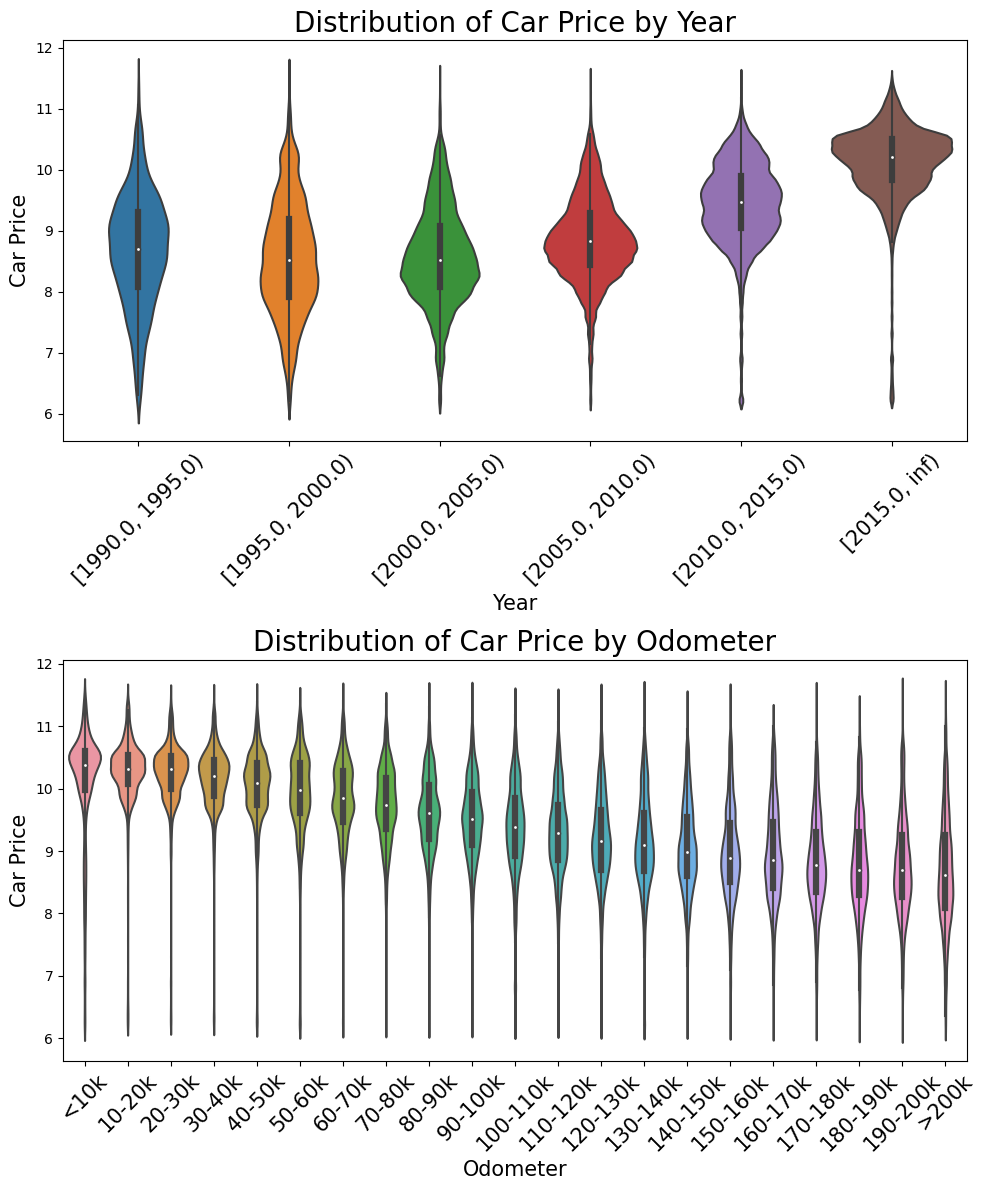

#### Cars in better condition fetching higher prices, while cars with more cylinders and those running on diesel are typically more expensive. Front-wheel-drive cars tend to be the most affordable.

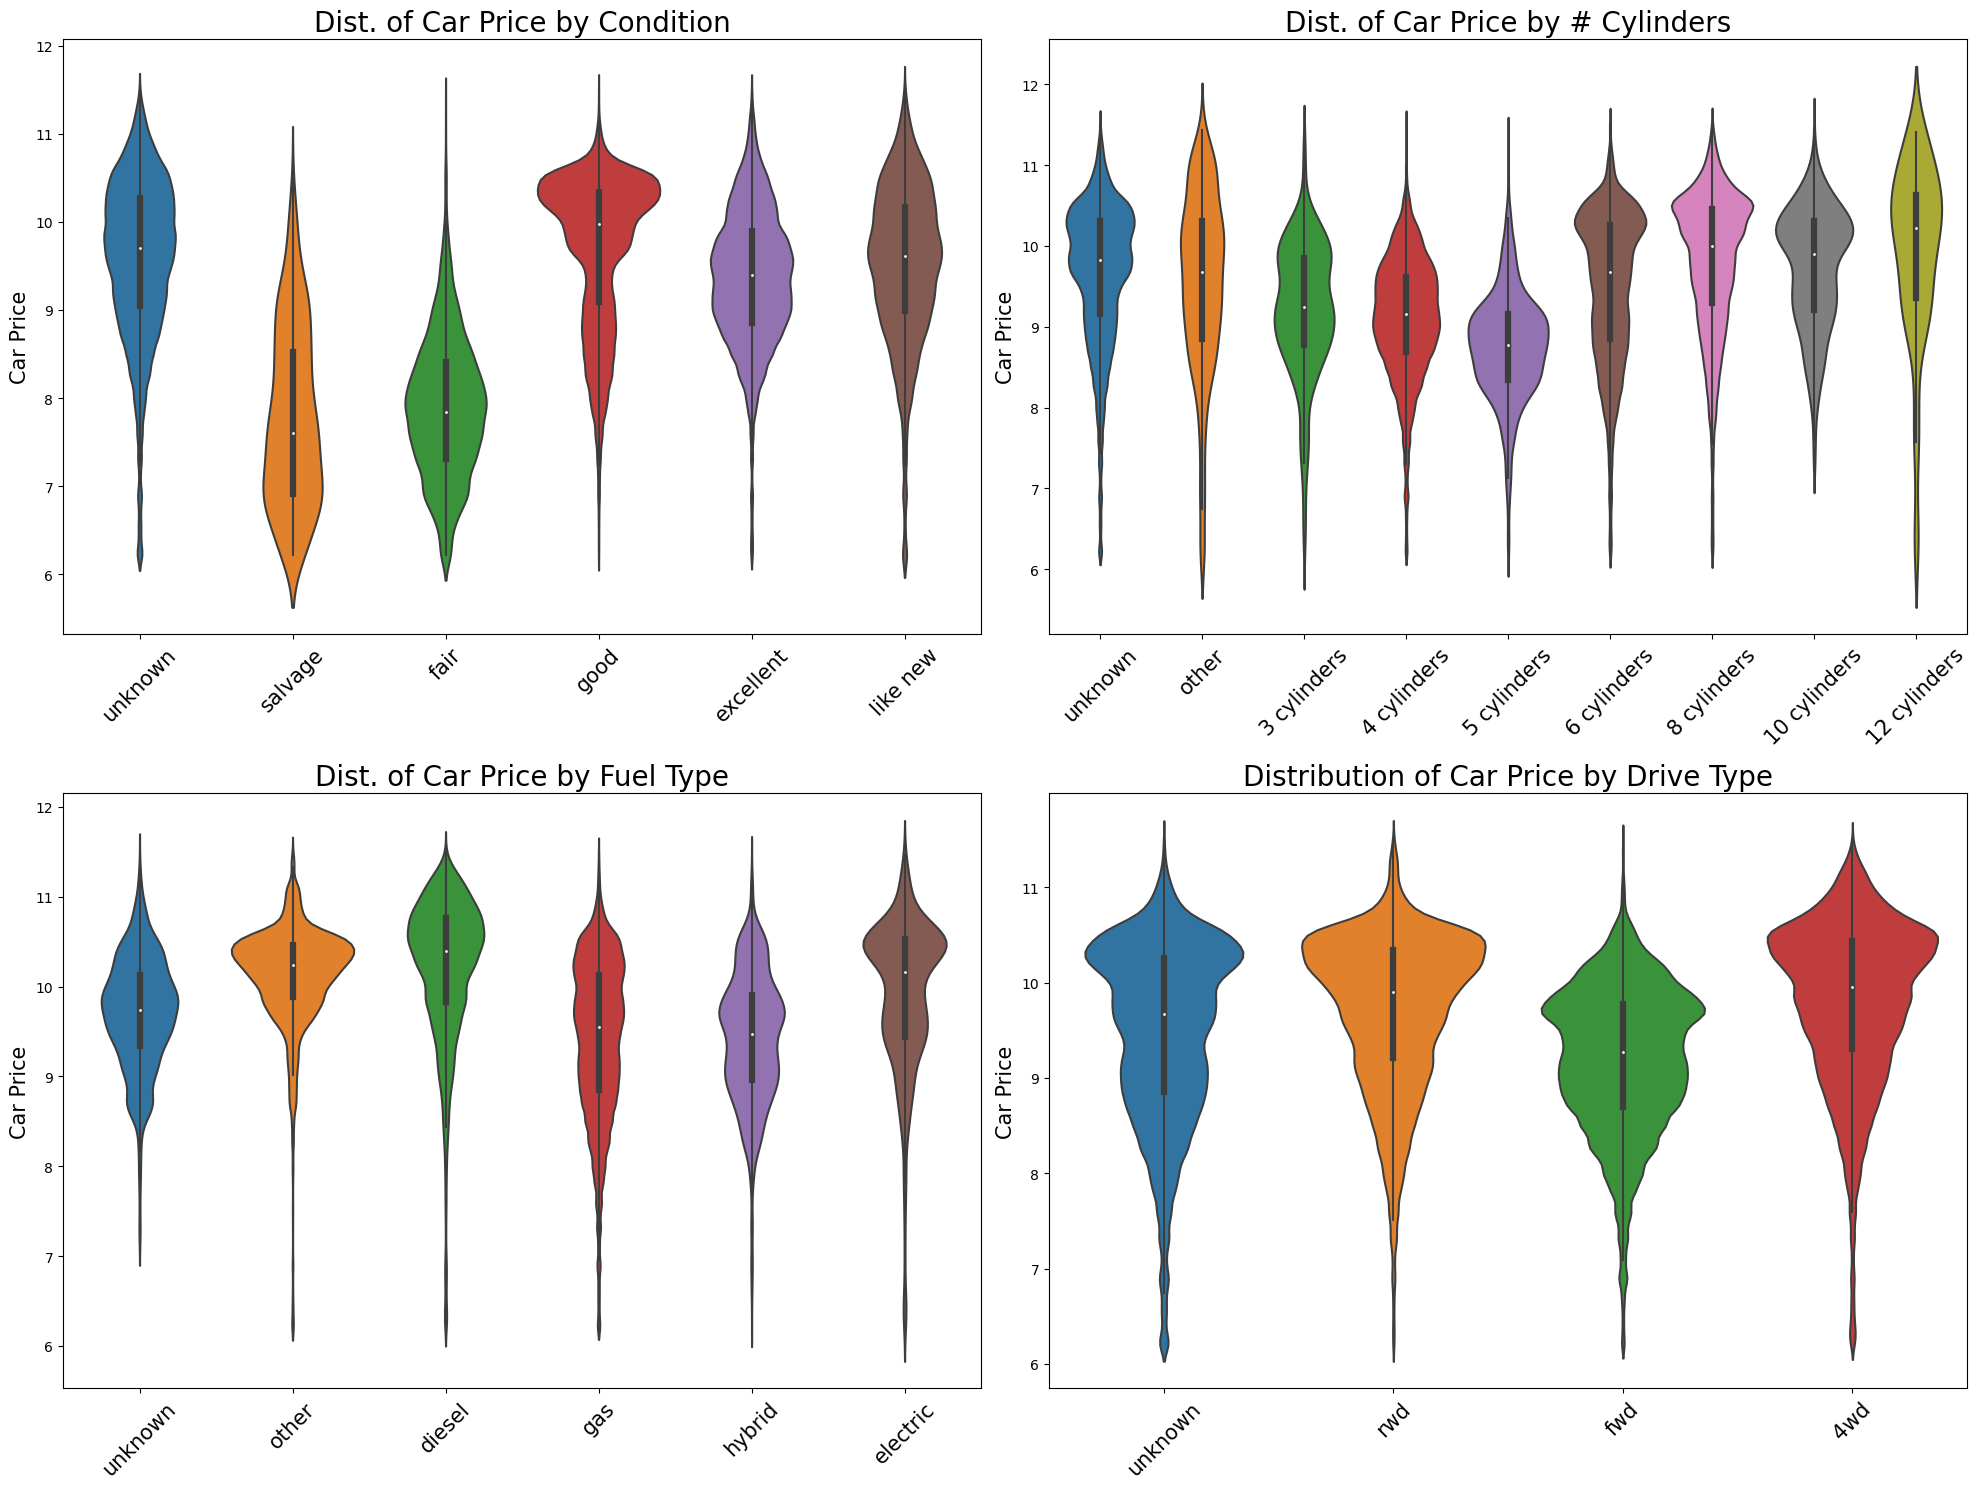

## Results of the best model:

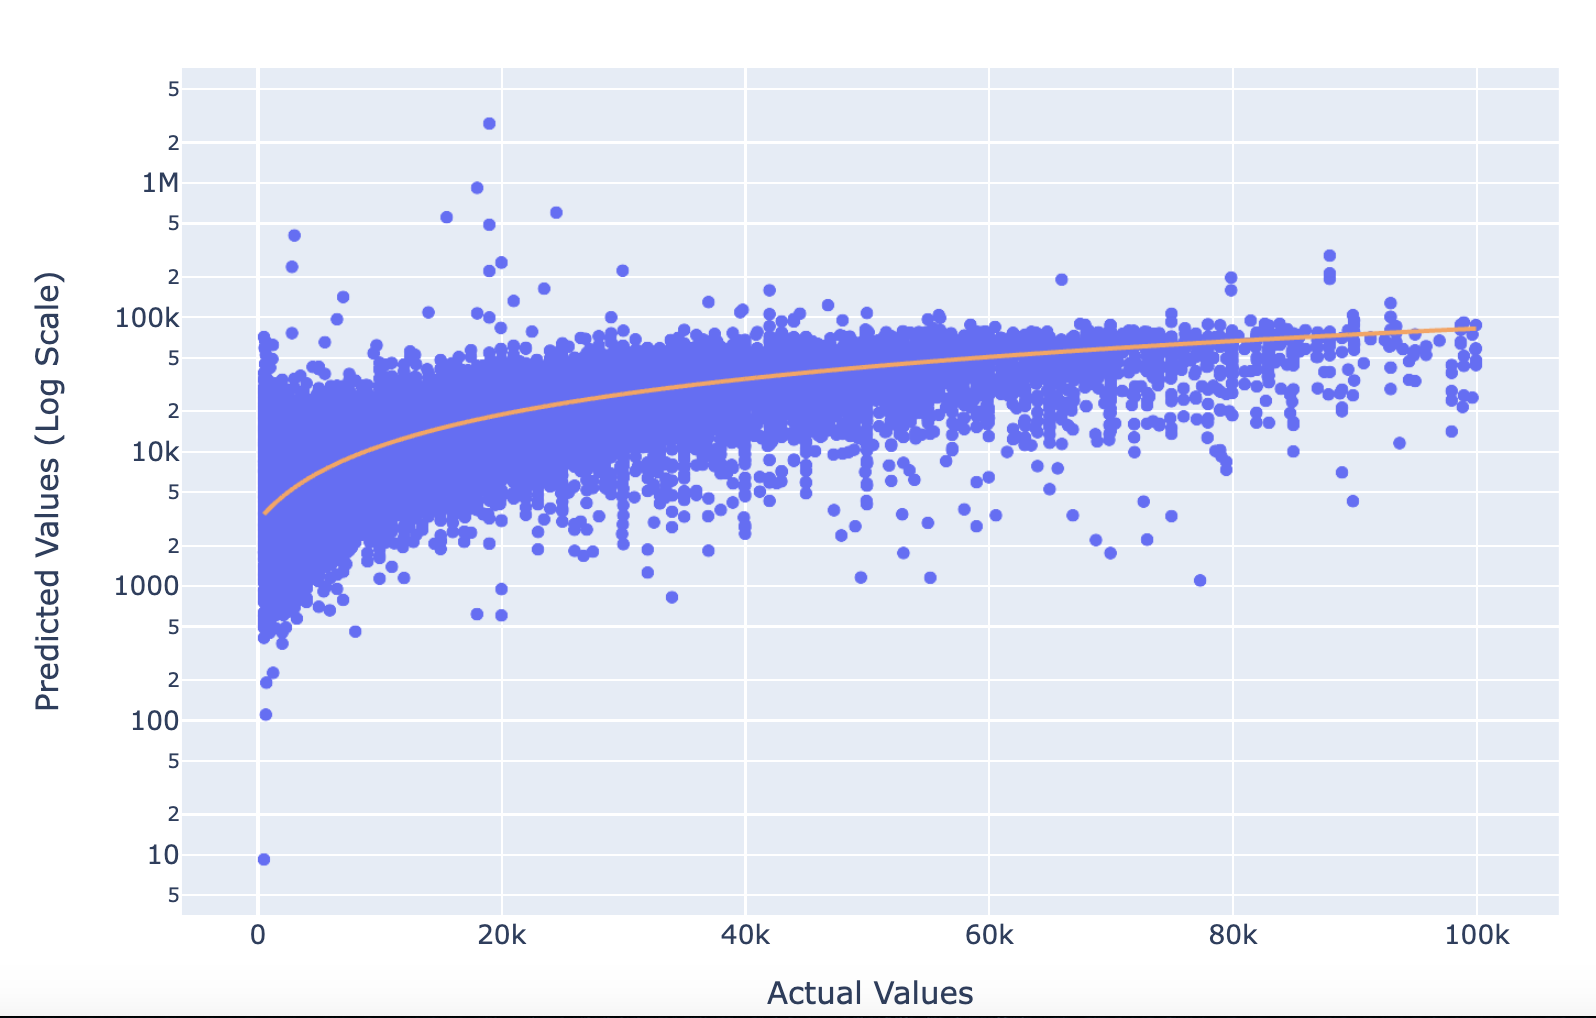

## Conclusion & Recommendations

Your inventory strategy should be informed by the insights gained from our Ridge regression analysis. Here's how you can align your approach with the key factors that drive car prices:

- **Age of the Vehicle**: Newer models significantly command higher values. **Action**: Focus on acquiring recent-year models.

- **Mileage**: Vehicles with fewer miles are worth more. **Action**: Select cars with lower odometer readings.

- **Condition**: The state of the vehicle is paramount. **Action**: Seek out cars in 'excellent' or 'like new' condition.

- **Cylinders**: More cylinders typically equate to higher prices due to increased power and performance. **Action**: Include higher-cylinder models in your premium segment.

- **Fuel Type**: Diesel, electric, and hybrid cars tend to be priced higher. **Action**: Diversify your inventory with a range of fuel-efficient vehicles.

- **Drive Type**: Front-wheel drive vehicles are generally more affordable. **Action**: Maintain a variety of drive types to cater to both budget and premium buyers.

Utilize these data-driven insights to refine your purchasing criteria and align your inventory with market demands, thereby enhancing turnover and profitability.
